
## PTB-XL Dataset Validation for LSTM Training

* Original **500 Hz, 12-lead ECG recordings** from PTB-XL are loaded using metadata-defined file paths.
* Recordings are filtered to include only **AFIB** (atrial fibrillation) and **NORM** (normal sinus rhythm) labels based on expert annotations.
* All other rhythm classes are excluded to ensure a clean binary classification setup.
* The final number of recordings per class is summarized and visualized using a **dataset composition diagram** for scietific reporting.




In [46]:
import os
import numpy as np
import pandas as pd
import ast
from collections import Counter, defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import wfdb
from scipy.signal import welch
print(os.path.exists("../data/records500"))



True


In [47]:
def load_ptbxl_metadata(dataset_root):
    df = pd.read_csv(os.path.join(dataset_root, "ptbxl_database.csv"))

    meta = {}
    for _, row in df.iterrows():
        scp_codes = ast.literal_eval(row["scp_codes"])

        if "AFIB" in scp_codes:
            label = 1
        elif "NORM" in scp_codes and "AFIB" not in scp_codes:
            label = 0
        else:
            continue

        # NORMALIZE PATH (important!)
        key = row["filename_hr"].replace("\\", "/")

        meta[key] = {
            "ecg_id": int(row["ecg_id"]),
            "patient_id": int(row["patient_id"]),
            "label": label,
        }

    return meta


In [48]:
def scan_records500(dataset_root, meta):
    records500_root = os.path.join(dataset_root, "records500")

    records = []
    skipped = 0

    for subdir in sorted(os.listdir(records500_root)):
        subdir_path = os.path.join(records500_root, subdir)
        if not os.path.isdir(subdir_path):
            continue

        for fname in os.listdir(subdir_path):
            if not fname.endswith(".hea"):
                continue

            stem = fname[:-4]  # remove .hea

            # FORCE FORWARD SLASHES
            key = f"records500/{subdir}/{stem}"

            if key not in meta:
                skipped += 1
                continue

            info = meta[key]

            records.append({
                "hea_path": os.path.join(subdir_path, fname),
                "dat_path": os.path.join(subdir_path, stem + ".dat"),
                "label": info["label"],
                "patient_id": info["patient_id"],
                "ecg_id": info["ecg_id"],
            })
            
    
   
    print(f"Total 500 Hz records loaded: {len(records)}")
    print(f"Records skipped (no metadata): {skipped}")
    


    return records


Total 500 Hz records loaded: 11005
Records skipped (no metadata): 10832
exaple record: {'hea_path': '../data/records500\\00000\\00001_hr.hea', 'dat_path': '../data/records500\\00000\\00001_hr.dat', 'label': 0, 'patient_id': 15709, 'ecg_id': 1}
AFIB records  : 1514
NORM records  : 9491


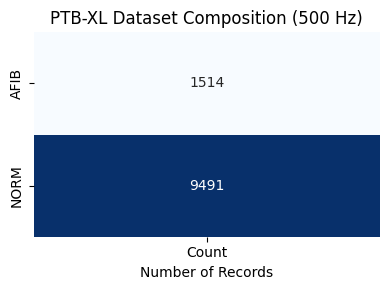

In [13]:
dataset_root = "../data/"

meta = load_ptbxl_metadata(dataset_root)
records = scan_records500(dataset_root, meta)
afib_records = [r for r in records if r["label"] == 1]
norm_records = [r for r in records if r["label"] == 0]
print("exaple record:", records[0])

print(f"AFIB records  : {len(afib_records)}")
print(f"NORM records  : {len(norm_records)}")
composition_df = pd.DataFrame({
    "Class": ["AFIB", "NORM"],
    "Count": [len(afib_records), len(norm_records)]
    })

composition_df



plt.figure(figsize=(4, 3))

sns.heatmap(
    composition_df.set_index("Class"),
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=False
)

plt.title("PTB-XL Dataset Composition (500 Hz)")
plt.ylabel("")
plt.xlabel("Number of Records")
plt.tight_layout()
plt.show()


# Loading Signals and dead leads detection phase
- **1** detection zero leads signals
- **2** Very low amplitude → electrode issue, poor contact
- **3** Very noisy → muscle activity (EMG), motion artifacts

### Detection zero-flat signals

In [ ]:


def detect_dead_leads(ecg, std_threshold=1e-4):
    """
    ecg: np.ndarray of shape (C, T) where C=12 leads
    returns: list of booleans (True = dead lead)
    """
    dead = []
    for lead in ecg:
        dead.append(np.std(lead) < std_threshold)
    return dead
#Repeated Loader function with QC
def load_ptbxl_signals_and_qc(dataset_root):
    meta_path = os.path.join(dataset_root, "ptbxl_database.csv")
    df = pd.read_csv(meta_path)

    rows = []

    for _, row in df.iterrows():
        scp_codes = ast.literal_eval(row["scp_codes"])

        # ---- Binary AFIB vs NORM filtering ----
        if "AFIB" in scp_codes:
            label = 1
        elif "NORM" in scp_codes and "AFIB" not in scp_codes:
            label = 0
        else:
            continue

        # ---- Load raw 500 Hz ECG ----
        record_path = os.path.join(dataset_root, row["filename_hr"])
        try:
            rec = wfdb.rdrecord(record_path)
        except Exception:
            continue

        if rec.p_signal is None:
            continue

        # Shape: (T, 12) → (12, T)
        signal = rec.p_signal.astype(np.float32).T

        # ---- Dead lead detection ----
        dead = detect_dead_leads(signal)

        rows.append({
            "ecg_id": int(row["ecg_id"]),
            "patient_id": int(row["patient_id"]),
            "label": "AFIB" if label == 1 else "NORM",
            "dead_leads": sum(dead),
            "working_leads": 12 - sum(dead),
            **{f"Lead_{i+1}_dead": dead[i] for i in range(12)}
        })

    return pd.DataFrame(rows)


In [18]:
dataset_root = "../data"
df_qc = load_ptbxl_signals_and_qc(dataset_root)

print(df_qc.head())
print(df_qc["label"].value_counts())


   ecg_id  patient_id label  dead_leads  working_leads  Lead_1_dead  \
0       1       15709  NORM           0             12        False   
1       2       13243  NORM           0             12        False   
2       3       20372  NORM           0             12        False   
3       4       17014  NORM           0             12        False   
4       5       17448  NORM           0             12        False   

   Lead_2_dead  Lead_3_dead  Lead_4_dead  Lead_5_dead  Lead_6_dead  \
0        False        False        False        False        False   
1        False        False        False        False        False   
2        False        False        False        False        False   
3        False        False        False        False        False   
4        False        False        False        False        False   

   Lead_7_dead  Lead_8_dead  Lead_9_dead  Lead_10_dead  Lead_11_dead  \
0        False        False        False         False         False   
1       

## **1** Result of Zero-flat signals either AFIM or NORM

label
NORM    9491
AFIB    1514
Name: count, dtype: int64


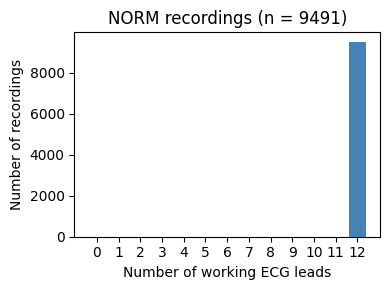

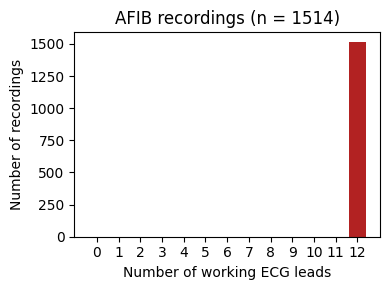

In [35]:
print(df_qc["label"].value_counts())
bins = np.arange(0, 14)

# ---- NORM ----
norm = df_qc[df_qc["label"] == "NORM"]["working_leads"]

plt.figure(figsize=(4, 3))
plt.hist(norm, bins=bins, align="left", rwidth=0.8, color="steelblue")
plt.title("NORM recordings (n = 9491)")
plt.xlabel("Number of working ECG leads")
plt.ylabel("Number of recordings")
plt.xticks(range(0, 13))
plt.tight_layout()
plt.show()

# ---- AFIB ----
afib = df_qc[df_qc["label"] == "AFIB"]["working_leads"]

plt.figure(figsize=(4, 3))
plt.hist(afib, bins=bins, align="left", rwidth=0.8, color="firebrick")
plt.title("AFIB recordings (n = 1514)")
plt.xlabel("Number of working ECG leads")
plt.ylabel("Number of recordings")
plt.xticks(range(0, 13))
plt.tight_layout()
plt.show()

## **2** Detect Low ampitutue 

In [52]:
def bandpower(x, fs, fmin, fmax):
    freqs, psd = welch(x, fs=fs, nperseg=2048)
    mask = (freqs >= fmin) & (freqs <= fmax)
    return np.trapezoid(psd[mask], freqs[mask])

def classify_lead(
    lead,
    fs,
    dead_std=1e-4,
    low_amp_std=0.02,
    noise_ratio_thresh=0.6,
):
    std = np.std(lead)

    # ---- DEAD ----
    if std < dead_std:
        return "dead", std, None

    # ---- LOW AMPLITUDE ----
    if std < low_amp_std:
        return "low_amplitude", std, None

    # ---- NOISE CHECK ----
    ecg_power = bandpower(lead, fs, 5, 15)
    hf_power  = bandpower(lead, fs, 30, 100)
    noise_ratio = hf_power / (ecg_power + 1e-8)

    if noise_ratio > noise_ratio_thresh:
        return "noisy", std, noise_ratio

    # ---- GOOD ----
    return "good", std, noise_ratio
def assess_record_quality(signal, fs):
    """
    signal: np.ndarray (12, T)
    returns: dict summary + per-lead details
    """

    per_lead = []
    counts = {
        "dead": 0,
        "low_amplitude": 0,
        "noisy": 0,
        "good": 0,
    }

    for i, lead in enumerate(signal):
        status, std, noise_ratio = classify_lead(lead, fs)

        counts[status] += 1

        per_lead.append({
            "lead": i + 1,
            "status": status,
            "std": std,
            "noise_ratio": noise_ratio,
        })

    return {
        "counts": counts,
        "usable_leads": counts["good"],
        "per_lead": per_lead,
    }



## New Loader

In [53]:
def load_ptbxl_with_quality(dataset_root):
    df = pd.read_csv(os.path.join(dataset_root, "ptbxl_database.csv"))
    rows = []

    for _, row in df.iterrows():
        scp = ast.literal_eval(row["scp_codes"])

        if "AFIB" in scp:
            label = "AFIB"
        elif "NORM" in scp and "AFIB" not in scp:
            label = "NORM"
        else:
            continue

        rec = wfdb.rdrecord(os.path.join(dataset_root, row["filename_hr"]))
        signal = rec.p_signal.T.astype(np.float32)

        qc = assess_record_quality(signal, fs=500)

        rows.append({
            "ecg_id": row["ecg_id"],
            "patient_id": row["patient_id"],
            "label": label,
            "usable_leads": qc["usable_leads"],
            "dead_leads": qc["counts"]["dead"],
            "low_amp_leads": qc["counts"]["low_amplitude"],
            "noisy_leads": qc["counts"]["noisy"],
        })

    return pd.DataFrame(rows)


## Testing Quality


In [54]:
df_quality = load_ptbxl_with_quality("../data")

print(df_quality.head())
print(df_quality["label"].value_counts())


   ecg_id  patient_id label  usable_leads  dead_leads  low_amp_leads  \
0       1     15709.0  NORM            12           0              0   
1       2     13243.0  NORM            12           0              0   
2       3     20372.0  NORM            11           0              0   
3       4     17014.0  NORM            12           0              0   
4       5     17448.0  NORM            12           0              0   

   noisy_leads  
0            0  
1            0  
2            1  
3            0  
4            0  
label
NORM    9491
AFIB    1514
Name: count, dtype: int64


In [55]:
df_norm = df_quality[df_quality["label"] == "NORM"]
df_afib = df_quality[df_quality["label"] == "AFIB"]


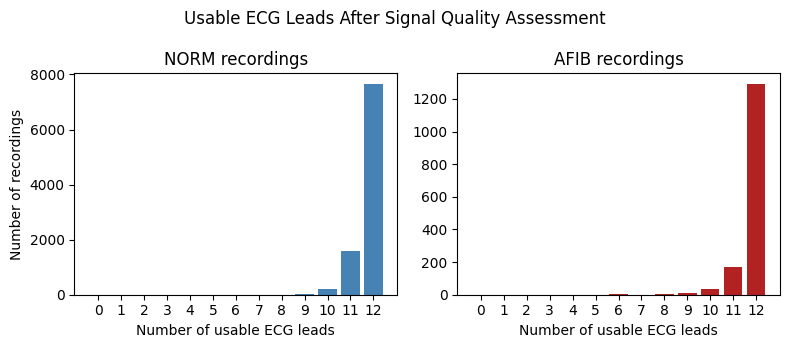

In [56]:
bins = np.arange(0, 14)

fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), sharey=False)

axes[0].hist(
    df_norm["usable_leads"],
    bins=bins,
    align="left",
    rwidth=0.8,
    color="steelblue"
)
axes[0].set_title("NORM recordings")
axes[0].set_xlabel("Number of usable ECG leads")
axes[0].set_ylabel("Number of recordings")
axes[0].set_xticks(range(0, 13))

axes[1].hist(
    df_afib["usable_leads"],
    bins=bins,
    align="left",
    rwidth=0.8,
    color="firebrick"
)
axes[1].set_title("AFIB recordings")
axes[1].set_xlabel("Number of usable ECG leads")
axes[1].set_xticks(range(0, 13))

plt.suptitle("Usable ECG Leads After Signal Quality Assessment")
plt.tight_layout()
plt.show()

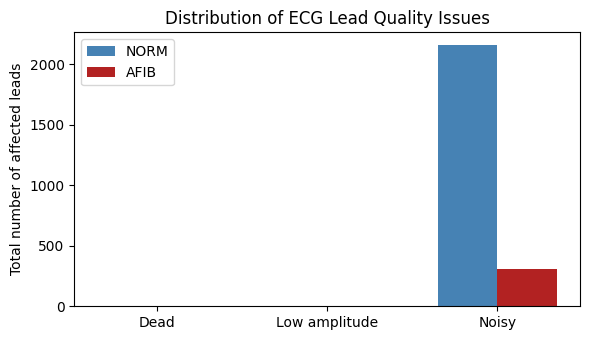

In [57]:
labels = ["Dead", "Low amplitude", "Noisy"]

norm_counts = [
    df_norm["dead_leads"].sum(),
    df_norm["low_amp_leads"].sum(),
    df_norm["noisy_leads"].sum(),
]

afib_counts = [
    df_afib["dead_leads"].sum(),
    df_afib["low_amp_leads"].sum(),
    df_afib["noisy_leads"].sum(),
]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6, 3.5))
plt.bar(x - width/2, norm_counts, width, label="NORM", color="steelblue")
plt.bar(x + width/2, afib_counts, width, label="AFIB", color="firebrick")

plt.xticks(x, labels)
plt.ylabel("Total number of affected leads")
plt.title("Distribution of ECG Lead Quality Issues")
plt.legend()
plt.tight_layout()
plt.show()


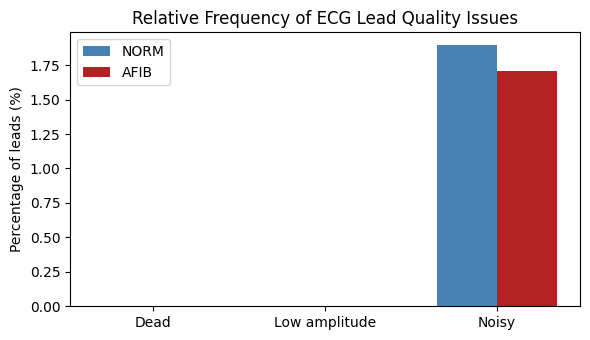

In [58]:
def percent_leads(df):
    total = len(df) * 12
    return [
        100 * df["dead_leads"].sum() / total,
        100 * df["low_amp_leads"].sum() / total,
        100 * df["noisy_leads"].sum() / total,
    ]

norm_pct = percent_leads(df_norm)
afib_pct = percent_leads(df_afib)

plt.figure(figsize=(6, 3.5))
plt.bar(x - width/2, norm_pct, width, label="NORM", color="steelblue")
plt.bar(x + width/2, afib_pct, width, label="AFIB", color="firebrick")

plt.xticks(x, labels)
plt.ylabel("Percentage of leads (%)")
plt.title("Relative Frequency of ECG Lead Quality Issues")
plt.legend()
plt.tight_layout()
plt.show()
